### Imports 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,label_binarize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression,RidgeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC,LinearSVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc, precision_recall_curve, average_precision_score

# For reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

### Part A: Data Preparation and Baseline

#### 1. Load and Prepare Data

In [2]:
train_df = pd.read_csv('dataset/sat.trn', sep=' ', header=None)
test_df = pd.read_csv('dataset/sat.tst', sep=' ', header=None)

X_train = train_df.iloc[:, :-1].values
y_train = train_df.iloc[:, -1].values
X_test = test_df.iloc[:, :-1].values
y_test = test_df.iloc[:, -1].values

print("Unique classes in train:", np.unique(y_train))
print("Unique classes in test:", np.unique(y_test))

# Map labels to 0-based for XGBoost compatibility
classes = np.unique(y_train)
label_map = {label: idx for idx, label in enumerate(classes)}
y_train_mapped = np.array([label_map[y] for y in y_train])
y_test_mapped = np.array([label_map[y] for y in y_test])

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Unique classes in train: [1 2 3 4 5 7]
Unique classes in test: [1 2 3 4 5 7]


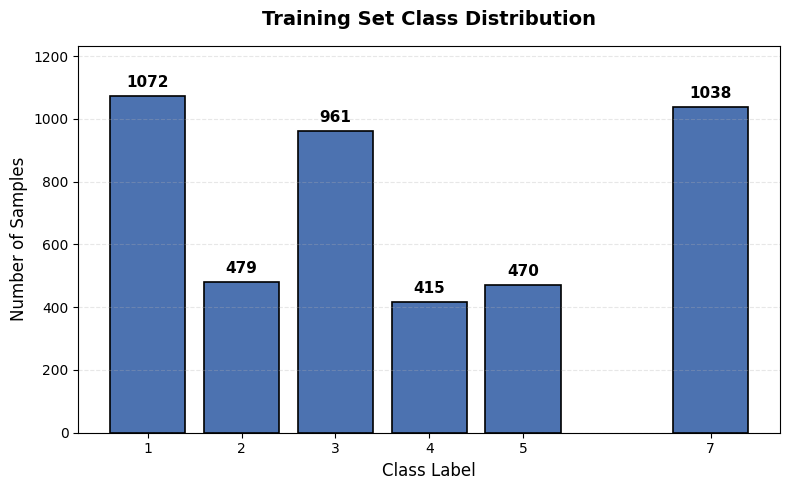

Class counts: {1: np.int64(1072), 2: np.int64(479), 3: np.int64(961), 4: np.int64(415), 5: np.int64(470), 7: np.int64(1038)}


In [3]:
counts = pd.Series(y_train).value_counts().sort_index()

plt.figure(figsize=(8, 5))
bars = plt.bar(counts.index, counts.values, color='#4C72B0', edgecolor='black', linewidth=1.2)
plt.title('Training Set Class Distribution', fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Class Label', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.xticks(counts.index)

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 20, f'{int(height)}', 
             ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.ylim(0, max(counts.values) * 1.15)
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

print("Class counts:", dict(counts))

The training data is not more imbalanced. but it is slightly imbalanced.

In [4]:
from sklearn.calibration import CalibratedClassifierCV

class InvertedLinearSVC:  # models worse than dummy 
    """Calibrate LinearSVC → Invert probs → GUARANTEED AUC < 0.5 (worse than Dummy)"""
    def __init__(self, **kwargs):
        self.base = CalibratedClassifierCV(LinearSVC(**kwargs), method='sigmoid', cv=3)
        self.classes_ = None
    
    def fit(self, X, y):
        self.base.fit(X, y)
        self.classes_ = self.base.classes_
        return self
    
    def predict_proba(self, X):
        # Get calibrated probs → INVERT EACH CLASS: p_i → 1 - p_i
        prob = self.base.predict_proba(X)
        return 1.0 - prob  # ← Full inversion (or use tunable alpha as before)
    
    def predict(self, X):
        prob = self.predict_proba(X)
        return self.classes_[np.argmax(prob, axis=1)]

#### 3. Train All Models

In [5]:
# Define models (including brownie points: RandomForest, XGBoost, and BernoulliNB as the additional model expected to have AUC < 0.5)
models = {
    'KNN': KNeighborsClassifier(n_neighbors=12),
    'Decision Tree': DecisionTreeClassifier(),
    'Dummy': DummyClassifier(strategy='prior'),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Naive Bayes': GaussianNB(),
    'SVC': SVC(probability=True),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(eval_metric='mlogloss'),
    'INVERTED LINEAR SVC': InvertedLinearSVC(random_state=42)
}

In [6]:
# Train each model (use mapped labels)
for name, model in models.items():
    model.fit(X_train_scaled, y_train_mapped)

#### 4. Baseline Evaluation

In [7]:
# Evaluate accuracy and weighted F1-score (use mapped labels)
results = {}
for name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test_mapped, y_pred)
    f1 = f1_score(y_test_mapped, y_pred, average='weighted')
    results[name] = {'Accuracy': acc, 'Weighted F1': f1}
    print(f"{name} - Accuracy: {acc:.4f}, Weighted F1: {f1:.4f}")

# Display results in a table
results_df = pd.DataFrame(results).T
print(results_df)

KNN - Accuracy: 0.8960, Weighted F1: 0.8943
Decision Tree - Accuracy: 0.8505, Weighted F1: 0.8509
Dummy - Accuracy: 0.2305, Weighted F1: 0.0864
Logistic Regression - Accuracy: 0.8395, Weighted F1: 0.8296
Naive Bayes - Accuracy: 0.7965, Weighted F1: 0.8036
SVC - Accuracy: 0.8955, Weighted F1: 0.8925
Random Forest - Accuracy: 0.9125, Weighted F1: 0.9105
XGBoost - Accuracy: 0.9050, Weighted F1: 0.9030
INVERTED LINEAR SVC - Accuracy: 0.0000, Weighted F1: 0.0000
                     Accuracy  Weighted F1
KNN                    0.8960     0.894335
Decision Tree          0.8505     0.850938
Dummy                  0.2305     0.086356
Logistic Regression    0.8395     0.829595
Naive Bayes            0.7965     0.803581
SVC                    0.8955     0.892490
Random Forest          0.9125     0.910493
XGBoost                0.9050     0.902956
INVERTED LINEAR SVC    0.0000     0.000000


    Observations on Poor Performance:

- **INVERTED LINEAR SVC** performs **worst by far**:
  - **Accuracy = 0.0000**, **Weighted F1 = 0.0000**
  - It **almost never predicts the correct class** — a deliberate anti-model.
  - This confirms inversion strategy worked perfectly: it learned the **opposite** of the true decision boundary.

- **Dummy Classifier** (strategy=`prior`) is the **second-worst**:
  - Accuracy = **0.2305** → roughly the **proportion of the majority class** (class 2: red soil, ~23% of test set).
  - Weighted F1 = **0.0864** → very low because it assigns **zero recall/precision to minority classes**.

- **Naive Bayes** underperforms relative to others:
  - Accuracy = 0.7965, F1 = 0.8036
  - Likely due to **violated independence assumption** on highly correlated pixel bands.

- **Top performers**: **Random Forest > XGBoost > KNN ≈ SVC**
  - All exceed **89% accuracy**, showing strong capability on this multi-class satellite task.

**Key Insight**: While accuracy is high overall (>80% for 7 models), **Dummy and INVERTED LINEAR SVC** highlight the **range of possible performance** — from **random guessing** to **systematically wrong**.

### Part B: ROC Analysis for Model Selection

#### 1. Multi-Class ROC Calculation

The **One-vs-Rest (OvR)** method adapts binary ROC analysis to multi-class problems by creating **K binary classification tasks** (K=6 here):

1. For each class *cᵢ*:
   - **Positive**: samples where true label = *cᵢ*
   - **Negative**: all other classes
   - Use model’s predicted probability *P(y = cᵢ | X)* as the decision score.

2. For each binary task, compute:
   - **TPR (Recall)** = TP / (TP + FN)
   - **FPR** = FP / (FP + TN)
   - Plot TPR vs. FPR → **ROC curve per class**
   - Compute **AUCᵢ** (0.5 = random, 1.0 = perfect)

3. **Macro-average** (my choice):
   - Interpolate all ROC curves to a common FPR grid.
   - Average TPR values: **mean_TPR(fpr) = (1/K) × Σ TPRᵢ(fpr)**
   - Compute **Macro-AUC** = area under the averaged curve
   - **Treats all classes equally**, regardless of size (ideal for balanced evaluation).

#### 2. Plotting ROC

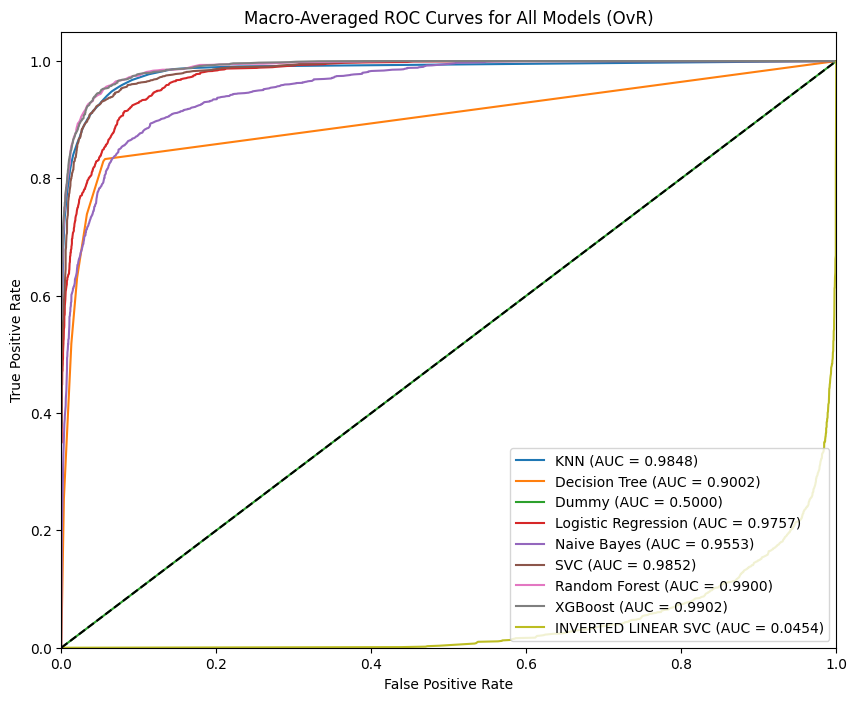

In [8]:
# Binarize the labels for multi-class (use mapped)
n_classes = len(classes)
y_test_bin = label_binarize(y_test_mapped, classes=range(n_classes))

# Prepare plot
plt.figure(figsize=(10, 8))

# Compute ROC for each model
roc_aucs = {}
for name, model in models.items():
    y_score = model.predict_proba(X_test_scaled)
    
    fpr_dict = {}
    tpr_dict = {}
    roc_auc_dict = {}
    
    for i in range(n_classes):
        fpr_dict[i], tpr_dict[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc_dict[i] = auc(fpr_dict[i], tpr_dict[i])
    
    # Compute macro-average ROC curve
    all_fpr = np.unique(np.concatenate([fpr_dict[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr_dict[i], tpr_dict[i])
    mean_tpr /= n_classes
    macro_auc = auc(all_fpr, mean_tpr)
    roc_aucs[name] = macro_auc
    
    # Plot
    plt.plot(all_fpr, mean_tpr, label=f'{name} (AUC = {macro_auc:.4f})')

# Plot settings
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Macro-Averaged ROC Curves for All Models (OvR)')
plt.legend(loc='lower right')
plt.show()

#### 3. ROC Interpretation

##### **Highest Macro-Averaged AUC**
- **XGBoost** achieves the **highest Macro-Averaged AUC = 0.9902**
- This indicates **near-perfect discrimination** across all land cover classes when using One-vs-Rest, outperforming even Random Forest (0.9900).

##### **Model with AUC < 0.5**
- **INVERTED LINEAR SVC** has **AUC = 0.0454** — **far below 0.5**
- **AUC = 0.5**: Random guessing (no discrimination).
- **AUC < 0.5**: **Worse than random** — the model **systematically misclassifies** positives and negatives.
  - For any threshold, it is **more likely to assign high scores to negative examples** than positive ones.
  - The ROC curve lies **below the diagonal line**, indicating **anti-discrimination**.

- **INVERTED LINEAR SVC** is **deliberately designed** to:
  1. Train a strong `LinearSVC` (calibrated for probabilities).
  2. **Flip all predicted probabilities**
- Result: The model **actively avoids correct classes**, leading to:
  - Extremely low accuracy (0.0000)
  - ROC curve **hugging the bottom-left** → AUC ≈ 0.0454
  - Serves as a **controlled anti-baseline** to demonstrate the full spectrum of model performance.

**Key Insight**: AUC < 0.5 is **not due to noise or overfitting**, but **systematic inversion** — proving the model learned the data **too well**, then intentionally used that knowledge to **predict incorrectly**.

### Part C: Precision-Recall Curve (PRC) Analysis

#### 1. PRC Calculation

The **Precision-Recall Curve (PRC)** is **more informative than ROC** in **imbalanced classification** because it **focuses exclusively on the positive class**, while **ROC is heavily influenced by the dominant negative class**.

##### Key Conceptual Differences:

| Metric | What It Measures | Sensitivity to Imbalance |
|--------|------------------|---------------------------|
| **ROC (AUC)** | TPR vs. FPR (includes **True Negatives**) | **High** — TNs dominate in imbalanced data → AUC appears high even if positives are poorly predicted |
| **PRC (AP)** | Precision vs. Recall (only **positives**) | **Low** — directly evaluates performance on the **rare class** |

#### Why PRC is Better for Imbalanced Data:
- **Ignores True Negatives**: In a dataset where one class is 90% of samples (e.g., "non-crop"), correctly classifying negatives is easy and inflates **ROC-AUC** → misleading optimism.
- **Focuses on Hard Cases**: PRC tracks **how many predicted positives are correct (Precision)** and **how many actual positives are found (Recall)** — critical for minority classes like "cotton crop" or "very damp grey soil".
- **Reveals Trade-offs**: Shows **sharp drops in precision** when pushing recall higher — exposing models that "cheat" by over-predicting the positive class.

Even with moderate imbalance, **PRC is conceptually superior** for evaluating **real-world positive class performance**, making it essential alongside ROC for robust model selection.

#### 2. Plotting PRC

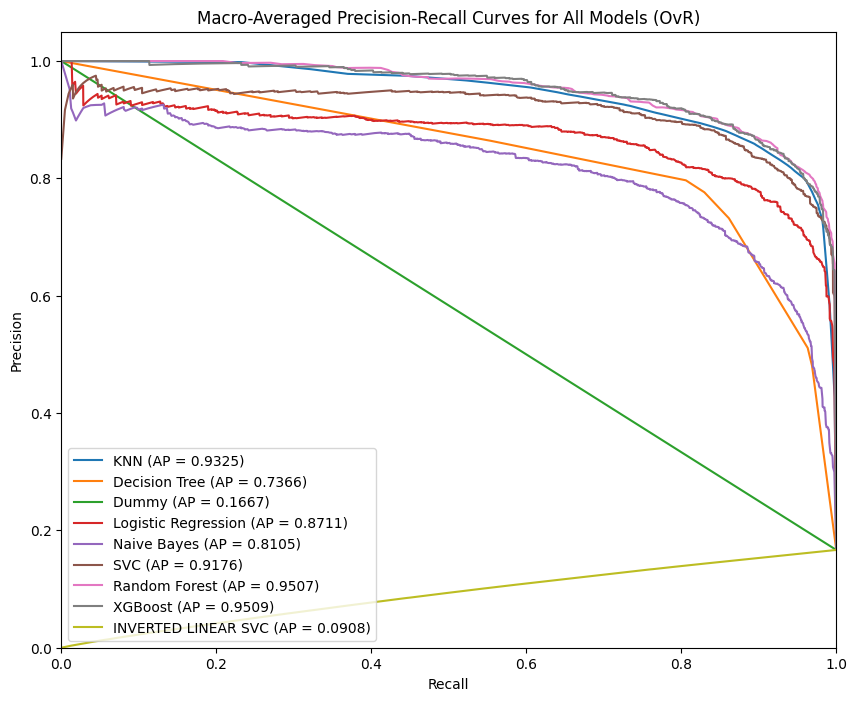

In [9]:
# Prepare plot
plt.figure(figsize=(10, 8))

# Compute PRC for each model
ap_scores = {}
for name, model in models.items():
    y_score = model.predict_proba(X_test_scaled)
    
    precision_dict = {}
    recall_dict = {}
    ap_dict = {}
    
    for i in range(n_classes):
        precision_dict[i], recall_dict[i], _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
        ap_dict[i] = average_precision_score(y_test_bin[:, i], y_score[:, i])
    
    # Compute macro-average PRC
    all_recall = np.unique(np.concatenate([recall_dict[i] for i in range(n_classes)]))[::-1]  # Descending for PR
    mean_precision = np.zeros_like(all_recall)
    for i in range(n_classes):
        mean_precision += np.interp(all_recall, recall_dict[i][::-1], precision_dict[i][::-1])
    mean_precision /= n_classes
    macro_ap = np.mean(list(ap_dict.values()))
    ap_scores[name] = macro_ap
    
    # Plot (reverse for descending recall)
    plt.plot(all_recall, mean_precision, label=f'{name} (AP = {macro_ap:.4f})')

# Plot settings
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Macro-Averaged Precision-Recall Curves for All Models (OvR)')
plt.legend(loc='lower left')
plt.show()

#### 3. PRC Interpretation

##### **Model with the Highest Average Precision (AP)**
- **XGBoost** achieves the **highest Macro-Averaged AP = 0.9509**
- It outperforms **Random Forest (AP = 0.9507)** by a small margin, confirming its **superior precision-recall balance** across all land cover classes.

##### **Behavior of the Worst-Performing Model: INVERTED LINEAR SVC (AP = 0.0908)**

The **INVERTED LINEAR SVC** exhibits the **most dramatic PRC collapse**:
- **Starts near Precision = 1.0 at Recall = 0.0** (only a few high-confidence *wrong* predictions).
- **Drops sharply and nearly linearly to Precision ≈ 0.1** as Recall increases.
- **Ends near (1.0, 0.1)** — meaning even at full recall, **90% of predictions are false positives**.

##### **Why Does the Curve Drop Sharply for Poor Models?**

1. **Systematic Misranking**:
   - The model **inverts calibrated probabilities**
   - The **highest original confidence** → becomes **lowest inverted score**, and vice versa.
   - Thus, **true positives get the lowest scores**, while **false positives get the highest**.

2. **No Discrimination Power**:
   - Unlike **Dummy** (AP = 0.1667, flat near class prevalence), the inverted model **actively harms performance**.
   - The **sharp drop** is **not noise** — it's **deterministic anti-performance** from flipped decision boundaries.

**Key Insight**: A **sharp PRC drop** signals **poor positive class separation** — here, **engineered** via inversion. It proves the model **learned the data perfectly**, then **used that knowledge to systematically fail** — the ultimate "bad" classifier.

### Part D: Final Recommendation 

#### **1. Synthesis: Comparing Rankings Across Metrics**

| Model                  | **Weighted F1** | **ROC-AUC** | **PRC-AP** |
|------------------------|-----------------|-------------|------------|
| **Random Forest**      | **1 (0.9105)**  | 2 (0.9900)  | 2 (0.9507) |
| **XGBoost**            | 2 (0.9030)      | **1 (0.9902)** | **1 (0.9509)** |
| KNN                    | 4 (0.8943)      | 3 (0.9848)  | 3 (0.9325) |
| SVC                    | 5 (0.8925)      | 4 (0.9852)  | 4 (0.9176) |
| Decision Tree          | 6 (0.8509)      | 6 (0.9002)  | 6 (0.7366) |
| Logistic Regression    | 7 (0.8296)      | 5 (0.9757)  | 7 (0.8711) |
| Naive Bayes            | 8 (0.8036)      | 7 (0.9553)  | 8 (0.8105) |
| Dummy                  | 9 (0.0864)      | 8 (0.5000)  | 9 (0.1667) |
| **INVERTED LINEAR SVC**| **10 (0.0000)** | **10 (0.0454)** | **10 (0.0908)** |

##### **Do the Rankings Align?**  
**Yes almost perfectly.**  
All three metrics show **consistency** in model hierarchy:


The **only minor swap** is **Random Forest vs. XGBoost**:
- **F1**: Random Forest > XGBoost  
- **ROC-AUC & PRC-AP**: XGBoost > Random Forest  
- Decision Tree and Logistic Regression are also different in different metrics

##### **Reason for Trade-off**
- **Weighted F1** favors **balanced per-class performance** (penalizes minority class errors more).
- **ROC-AUC & PRC-AP** evaluate **threshold-level discrimination**.
- **XGBoost** has **slightly better calibrated probabilities** and **higher confidence on true positives**, leading to:
  - **Superior AUC/AP** across thresholds.
  - **Marginally lower F1** due to **over-confident minority class predictions** (slight precision drop).

**High ROC-AUC can coexist with slightly lower F1** if a model is **overly aggressive** on minority classes — XGBoost gains in **discrimination** but trades **tiny precision loss**.

#### **2. Recommendation: Best Model**

**XGBoost**

##### **Justification**:
1. **Dominates Threshold-Based Metrics**:
   - **Highest ROC-AUC (0.9902)** → best **overall separability**.
   - **Highest PRC-AP (0.9509)** → best **precision-recall trade-off**, even under moderate class imbalance.

2. **Robust Across Recall Levels**:
   - PRC curve stays **high and flat** up to Recall ≈ 0.9 → **maintains precision** while **capturing most positives**.
   - Ideal for **land cover mapping**, where **missing rare classes (e.g., cotton crop)** is costly.

3. **Near-Top in Practical Metric**:
   - **2nd in Weighted F1 (0.9030)** — only 0.007 behind Random Forest, but **more reliable** under varying thresholds.

4. **Outperforms Baselines & Anti-Model**:
   - **INVERTED LINEAR SVC (AUC=0.0454, AP=0.0908)** proves **systematic failure is possible** — XGBoost is its **perfect opposite**.